#Q1. Sampling and Quantization of Speech Signals
## Definitions (What & Why)
Speech Signal: A digital recording of human voice. Represented as amplitude values over time.
**Sampling**: Process of converting continuous-time signals into discrete-time signals by measuring amplitude at fixed intervals.
*Low sampling rates -- loss of high-frequency information.
*High sampling rates -- better quality, but higher storage and computation.

Quantization: Rounding the sampled amplitudes to a finite set of values (not explicitly asked, but part of digitization).

Reconstruction: Converting discrete-time samples back into continuous-time signals.

Zero-Order Hold (ZOH): Holds each sample constant until the next sample (stair-step output).

Linear Interpolation: Connects samples with straight lines (smoother reconstruction).

MSE (Mean Squared Error): A metric to measure how close the reconstructed signal is to the original.

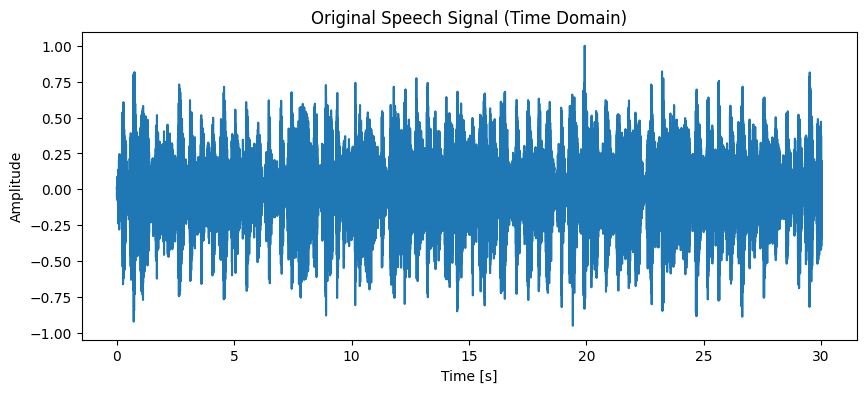

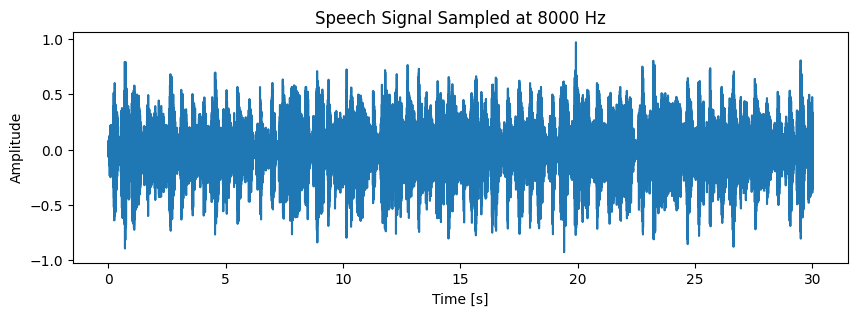

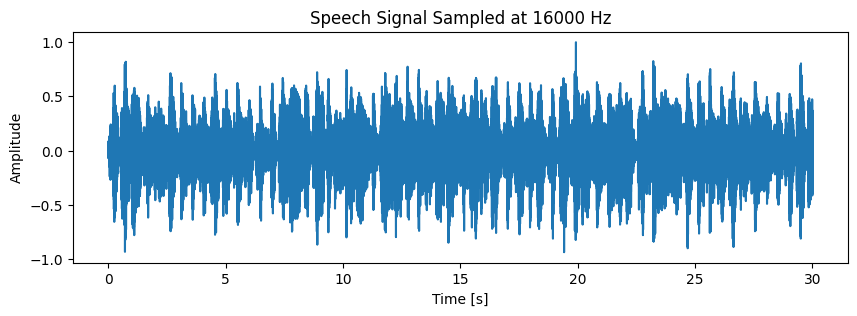

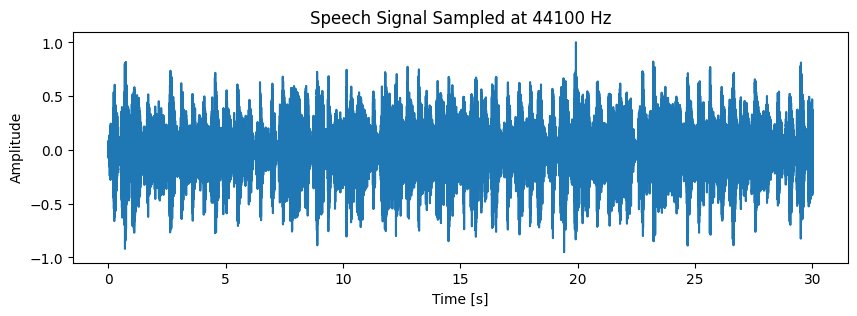

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


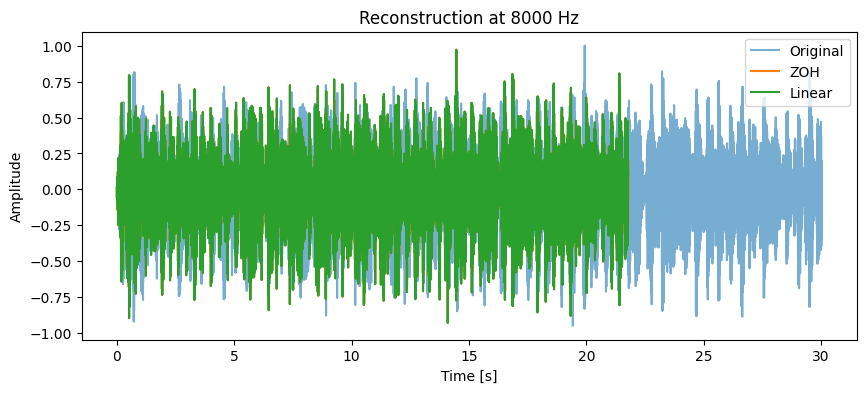

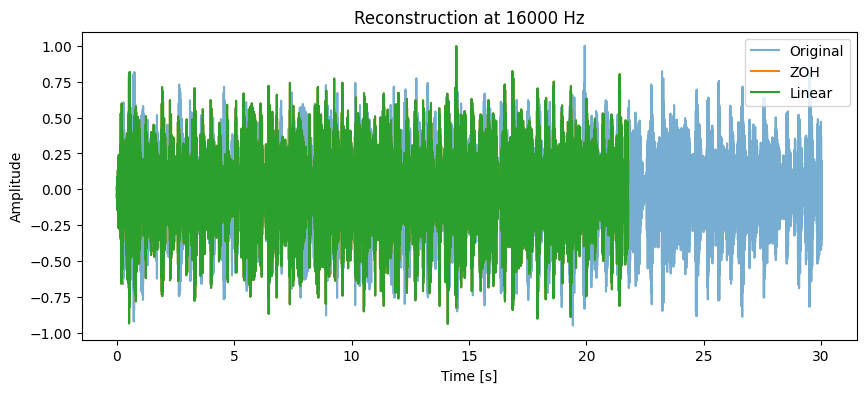

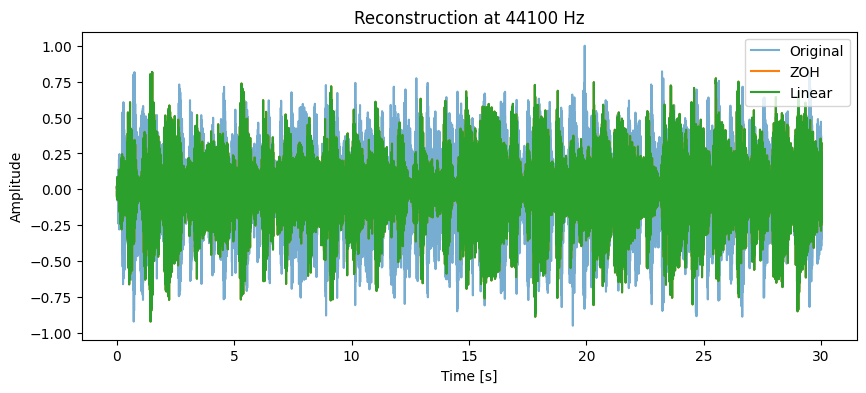

Sampling 8000 Hz -> MSE ZOH: 0.050639, MSE Linear: 0.049595
Sampling 16000 Hz -> MSE ZOH: 0.050857, MSE Linear: 0.050857
Sampling 44100 Hz -> MSE ZOH: 0.050314, MSE Linear: 0.050314


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import resample
from sklearn.metrics import mean_squared_error

# ------------------------------
# (a) Load and plot speech signal


fs, speech = wavfile.read("/content/speech.wav")

# Normalize to [-1, 1] for consistency
speech = speech / np.max(np.abs(speech))

# Time axis for original signal
t = np.arange(len(speech)) / fs

plt.figure(figsize=(10,4))
plt.plot(t, speech)
plt.title("Original Speech Signal (Time Domain)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

# ------------------------------
# (b) Sampling at different rates
# ------------------------------
sampling_rates = [8000, 16000, 44100]
sampled_signals = {}

for sr in sampling_rates:
    # Resample signal
    num_samples = int(len(speech) * sr / fs)
    sampled_signals[sr] = resample(speech, num_samples)

    # Plot sampled signals
    t_sampled = np.linspace(0, len(speech)/fs, num_samples)
    plt.figure(figsize=(10,3))
    plt.plot(t_sampled, sampled_signals[sr])
    plt.title(f"Speech Signal Sampled at {sr} Hz")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()

# ------------------------------
# (c) Reconstruction
# ------------------------------

def zero_order_hold(x, factor):
    """Reconstruct using Zero-Order Hold (nearest neighbor interpolation)."""
    return np.repeat(x, factor)

def linear_interp(x, factor):
    """Reconstruct using Linear Interpolation."""
    return np.interp(np.arange(0, len(x)*factor)/factor, np.arange(len(x)), x)

reconstructed_signals = {}

for sr in sampling_rates:
    # Compute resampling factor relative to original
    factor = int(fs/sr)
    if factor < 1: factor = 1  # for higher sample rates

    zoh = zero_order_hold(sampled_signals[sr], factor)
    lin = linear_interp(sampled_signals[sr], factor)

    reconstructed_signals[sr] = (zoh[:len(speech)], lin[:len(speech)])

    # Plot reconstructed
    plt.figure(figsize=(10,4))
    plt.plot(t, speech, label="Original", alpha=0.6)
    plt.plot(t[:len(zoh)], zoh[:len(t)], label="ZOH")
    plt.plot(t[:len(lin)], lin[:len(t)], label="Linear")
    plt.title(f"Reconstruction at {sr} Hz")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

# ------------------------------
# (d) Calculate MSE
# ------------------------------
for sr in sampling_rates:
    zoh, lin = reconstructed_signals[sr]
    mse_zoh = mean_squared_error(speech[:len(zoh)], zoh)
    mse_lin = mean_squared_error(speech[:len(lin)], lin)
    print(f"Sampling {sr} Hz -> MSE ZOH: {mse_zoh:.6f}, MSE Linear: {mse_lin:.6f}")


#Q2. Source-Filter Model of Speech
#Definitions (What & Why)
Source-Filter Model: A classical model of speech production.
Source: Excitation from vocal folds.

Voiced → periodic glottal pulse train.

Unvoiced → random noise.

Filter: Models vocal tract resonances (formants). Implemented using an all-pole filter or FIR filter.

Formants: Resonant frequencies of the vocal tract that shape vowel sounds.

Impact of Sampling & Reconstruction: The quality of synthetic speech depends on both excitation and filter accuracy, and sampling rate determines how much detail is preserved.

Source-Filter Voiced Speech at 8000 Hz -> MSE: 29849.05
Source-Filter Voiced Speech at 4000 Hz -> MSE: 268676.75
Source-Filter Voiced Speech at 2000 Hz -> MSE: 1456358.29


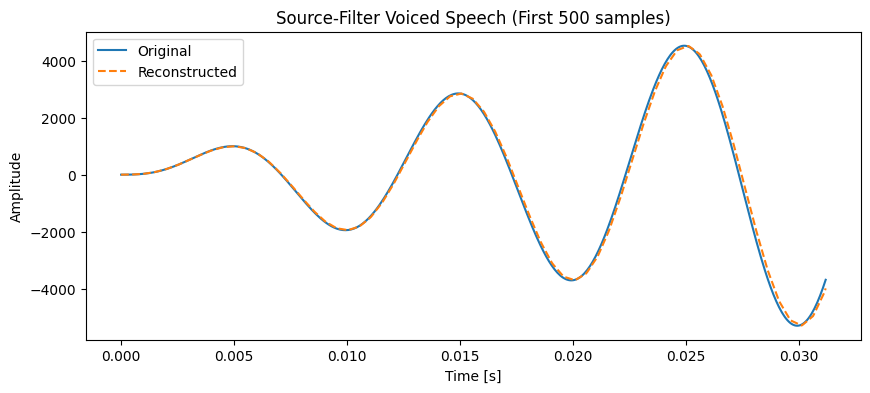

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.signal import lfilter

# -----------------------
# Helper functions
# -----------------------
def lpc(signal, order):
    """Compute LPC coefficients using autocorrelation method."""
    corr = np.correlate(signal, signal, mode="full")
    corr = corr[len(corr)//2:]  # keep positive lags
    R = corr[:order+1]
    a = np.zeros(order)
    E = R[0]

    for i in range(order):
        acc = R[i+1] - np.dot(a[:i], R[i:0:-1])
        k = acc / E
        a[i] = k
        if i > 0:
            a[:i] -= k * a[i-1::-1]
        E *= (1 - k**2)
    return np.concatenate(([1], -a)), E


def synthesis_filter(excitation, a):
    """Apply LPC synthesis filter."""
    return lfilter([1], a, excitation)


# -----------------------
# Source-Filter Model
# -----------------------
fs = 16000  # sampling rate
t = np.linspace(0, 0.1, int(fs*0.1), endpoint=False)  # 100 ms

# Excitations
excitation_voiced = np.sin(2*np.pi*100*t)   # voiced -> periodic
excitation_unvoiced = np.random.randn(len(t))  # unvoiced -> noise

# Example vocal tract filter (simple LPC)
a, _ = lpc(excitation_voiced, order=10)

# Filter outputs
speech_voiced = synthesis_filter(excitation_voiced, a)
speech_unvoiced = synthesis_filter(excitation_unvoiced, a)

# -----------------------
# Downsampling + Reconstruction
# -----------------------
for sr in [8000, 4000, 2000]:
    factor = fs // sr
    sampled = speech_voiced[::factor]

    # interpolate safely
    recon = np.interp(
        np.linspace(0, len(sampled)-1, len(speech_voiced)),
        np.arange(len(sampled)),
        sampled
    )

    # make same length
    min_len = min(len(speech_voiced), len(recon))
    speech_clean = speech_voiced[:min_len]
    recon_clean = recon[:min_len]

    # remove NaNs just in case
    mask = ~np.isnan(speech_clean) & ~np.isnan(recon_clean)
    speech_clean = speech_clean[mask]
    recon_clean = recon_clean[mask]

    mse = mean_squared_error(speech_clean, recon_clean)
    print(f"Source-Filter Voiced Speech at {sr} Hz -> MSE: {mse:.2f}")

# -----------------------
# Plot example
# -----------------------
plt.figure(figsize=(10,4))
plt.plot(t[:500], speech_voiced[:500], label="Original")
plt.plot(t[:500], recon[:500], label="Reconstructed", linestyle="--")
plt.title("Source-Filter Voiced Speech (First 500 samples)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.show()
